## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from srs.analysis import read_data, plot_missing_values, plot_max_median, plot_correlation_between_stations, \
    remove_outliers, interpolate_missing_values, calculate_mean_value_across_all_stations, save_mean_data, \
    plot_change_between_consecutive_hours, plot_diff_between_stations

## Read data

In [3]:
data = read_data('NO')
stations = data.columns.tolist()[1:]

In [4]:
stations

['WpPoznDabrow', 'WpPoznPolank', 'WpPoznRatajeMOB']

In [5]:
data

Time  WpPoznDabrow  WpPoznPolank  WpPoznRatajeMOB
0    2020-01-01 01:00:00       1.12923       1.67319          0.07056
1    2020-01-01 02:00:00       1.50748       1.45381          0.09504
2    2020-01-01 03:00:00       1.30589       1.54059          0.09920
3    2020-01-01 04:00:00       1.42470       1.49931          0.07080
4    2020-01-01 05:00:00       1.13304       1.45977          0.07565
...                  ...           ...           ...              ...
8778 2020-12-31 19:00:00      23.97050      15.73030         83.87880
8779 2020-12-31 20:00:00      23.94140      10.02030         39.78760
8780 2020-12-31 21:00:00      13.08280       7.07776         29.75930
8781 2020-12-31 22:00:00      10.15090       4.56087         43.53170
8782 2020-12-31 23:00:00       5.20830       4.20344         27.52820

[8783 rows x 4 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8783 entries, 0 to 8782
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             8783 non-null   datetime64[ns]
 1   WpPoznDabrow     8679 non-null   float64       
 2   WpPoznPolank     8690 non-null   float64       
 3   WpPoznRatajeMOB  8766 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 343.1 KB


In [7]:
data.describe().T

count      mean        std      min       25%      50%  \
WpPoznDabrow     8679.0  6.957447  20.485906  0.11431  1.031370  2.13479   
WpPoznPolank     8690.0  5.666654  13.301442  0.01686  0.531038  1.55067   
WpPoznRatajeMOB  8766.0  4.290404  11.777135  0.01074  0.279625  0.98045   

                      75%      max  
WpPoznDabrow     4.896035  418.139  
WpPoznPolank     4.797928  290.615  
WpPoznRatajeMOB  3.180112  215.746

### Investigate missing values

In [8]:
data.isnull().mean().round(3)

Time               0.000
WpPoznDabrow       0.012
WpPoznPolank       0.011
WpPoznRatajeMOB    0.002
dtype: float64

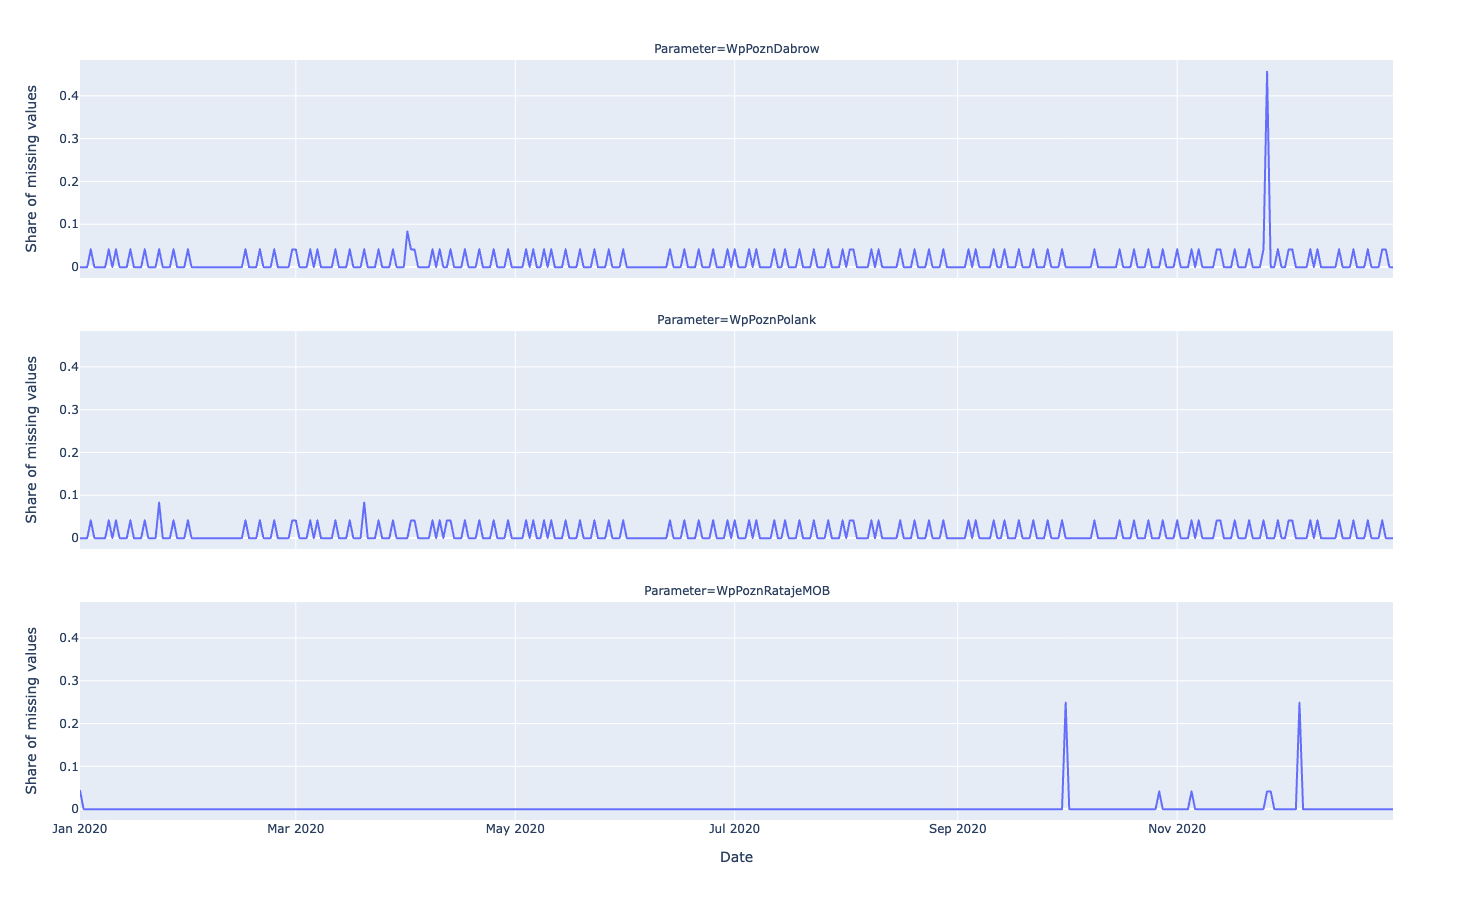

In [9]:
plot_missing_values(data, stations)

The missing values are spread throught the whole data range, these should be easy to interpolate.

## EDA

**Maximum and median values**

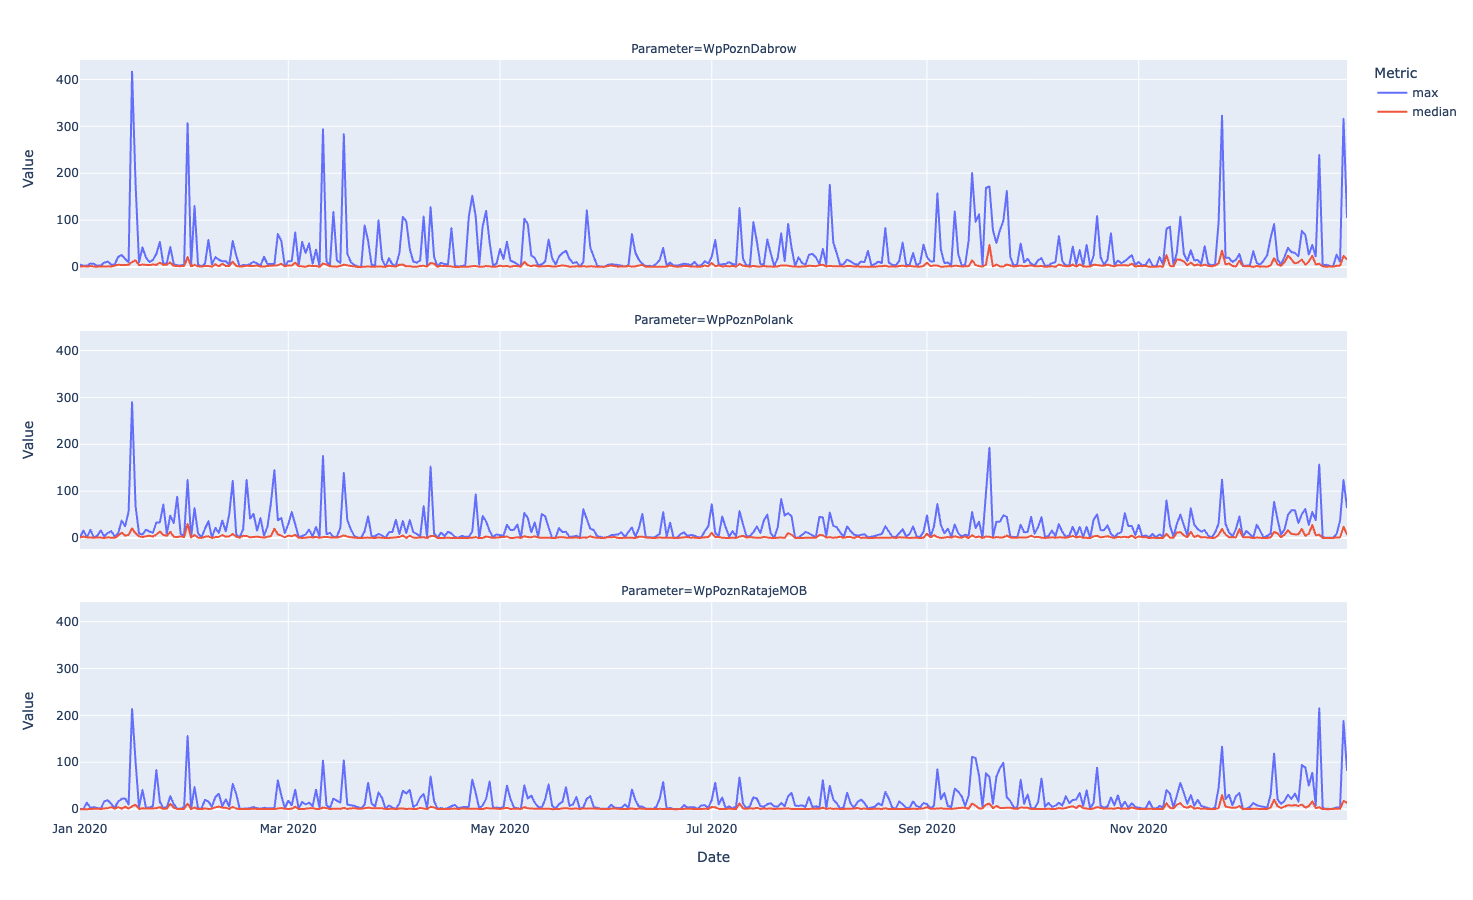

In [10]:
plot_max_median(data, stations)

It looks like there are just moments throughout the day when the concentration is very high, but it does not last long.

**Correlation between stations**

The data has to be transformed for the pattern to occur.

In [11]:
data_log = data.copy()

for s in stations:
    data_log[s] = np.log(data[s])

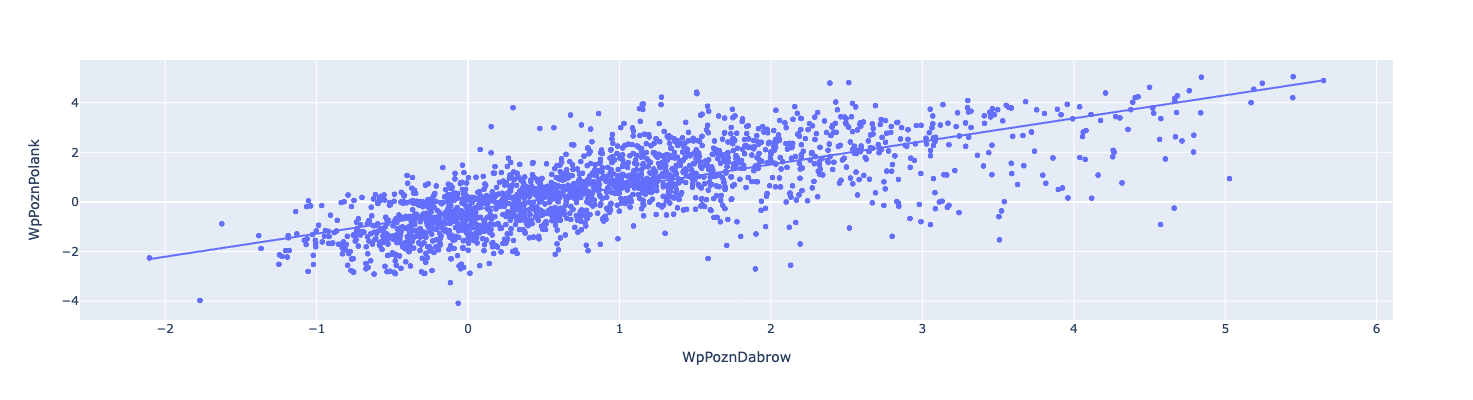

In [12]:
plot_correlation_between_stations(data_log, stations[0], stations[1])

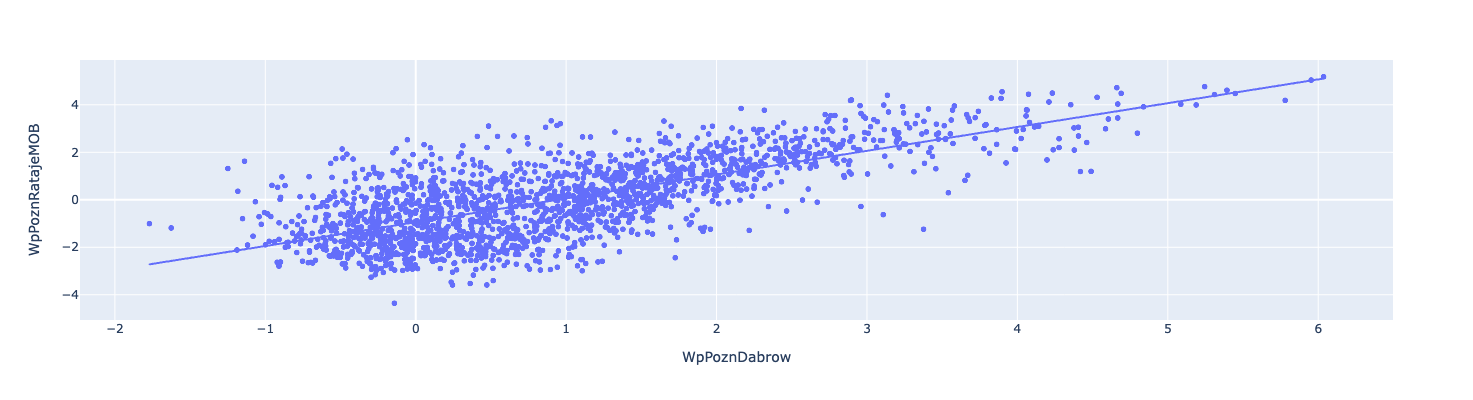

In [13]:
plot_correlation_between_stations(data_log, stations[0], stations[2])

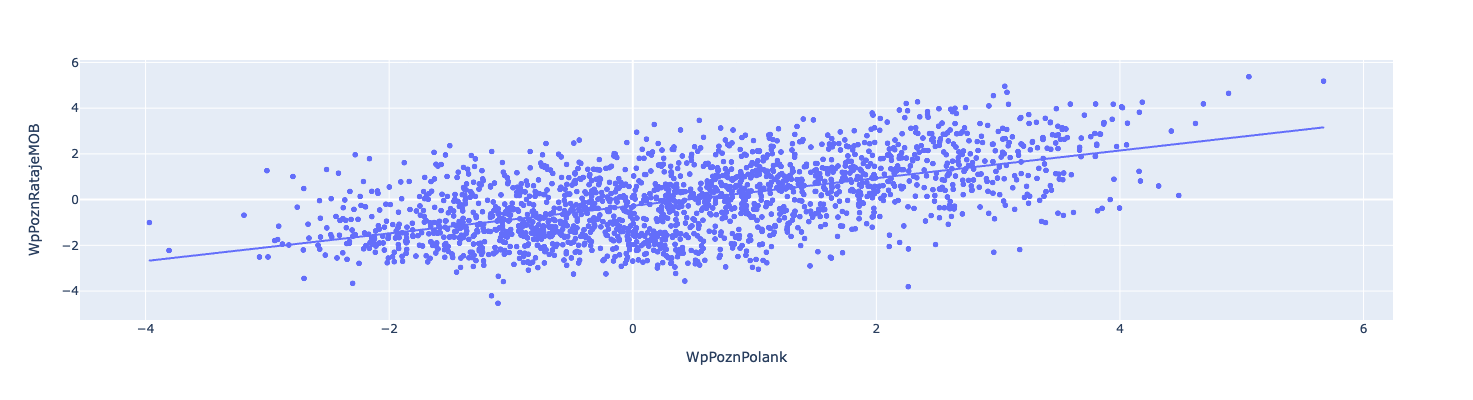

In [14]:
plot_correlation_between_stations(data_log, stations[1], stations[2])

What's interesting, the measurements of stations are not linearly correlated. I had to make logarytmic transformation to see the pattern.

**Change between consecutive hours**

                Difference                                
                      mean    median        max        std
Parameter                                                 
WpPoznDabrow     -0.004792 -0.051440  276.43200  12.612598
WpPoznPolank     -0.003211 -0.026875  117.53311   7.836203
WpPoznRatajeMOB  -0.001918 -0.014200  129.82360   6.527938


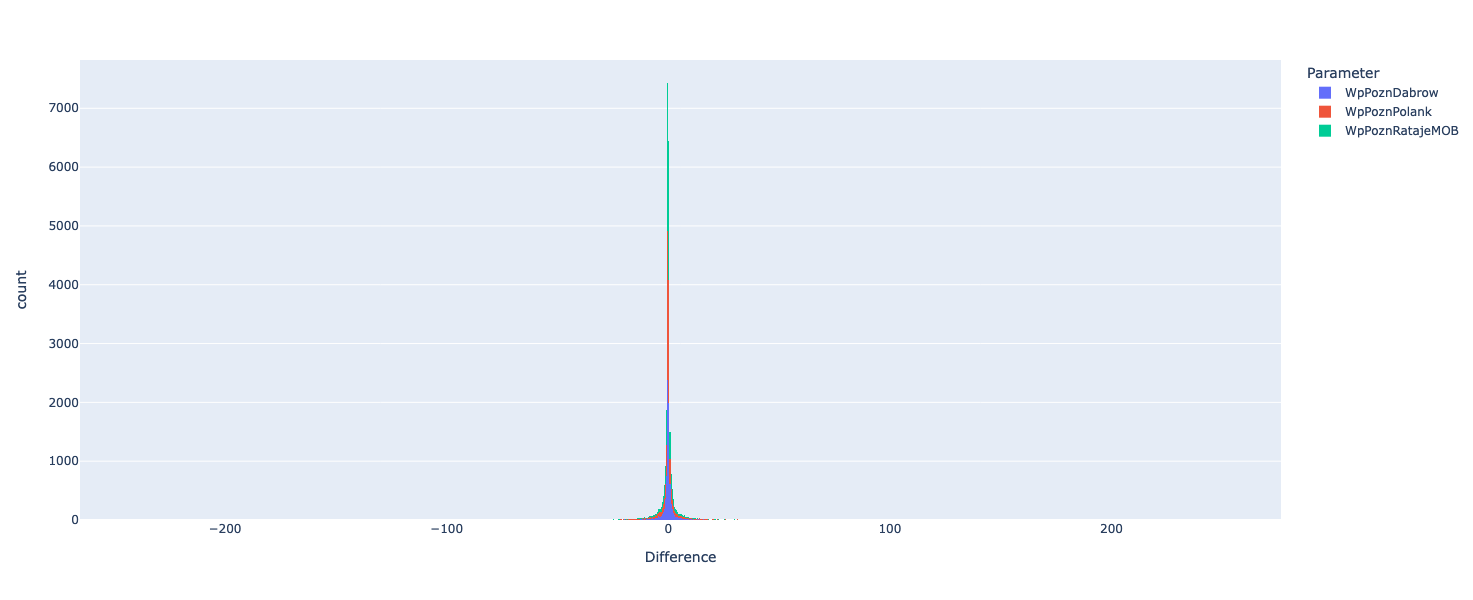

In [15]:
plot_change_between_consecutive_hours(data, stations)

This distribution is not surprising after the observation we made when analysing max and median values. There rapid changes in pollution which happen from time to time.

**Difference between stations**

mean       -1.307793
median     -0.397825
max       141.421140
std        14.979649
Name: Difference, dtype: float64


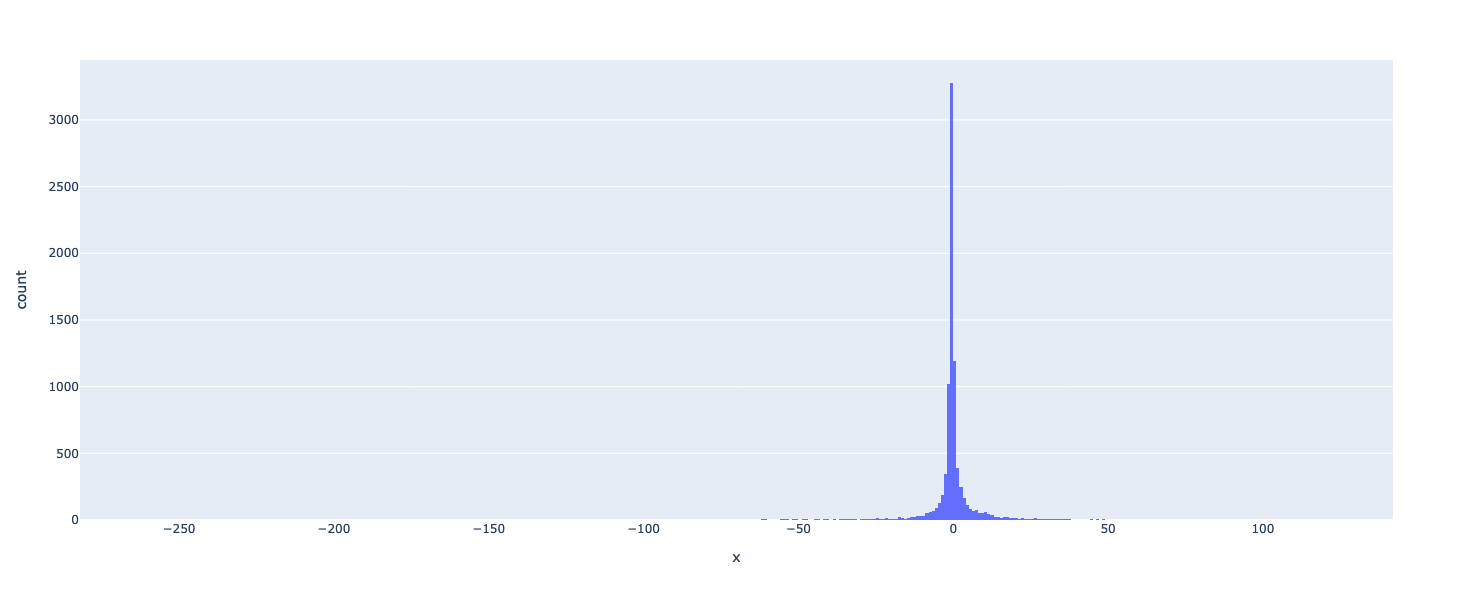

In [16]:
plot_diff_between_stations(data, stations[0], stations[1])

mean       -2.686157
median     -0.936420
max       121.146900
std        13.502219
Name: Difference, dtype: float64


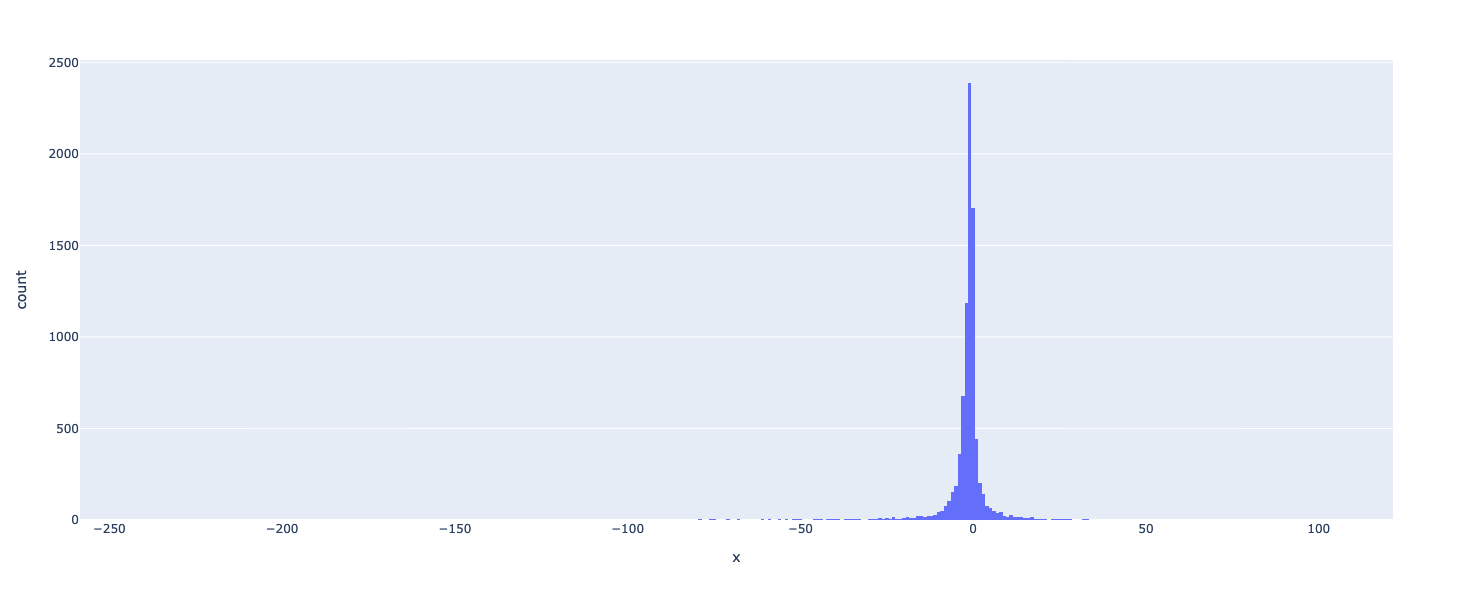

In [17]:
plot_diff_between_stations(data, stations[0], stations[2])

mean       -1.374075
median     -0.306670
max       124.464600
std        10.747654
Name: Difference, dtype: float64


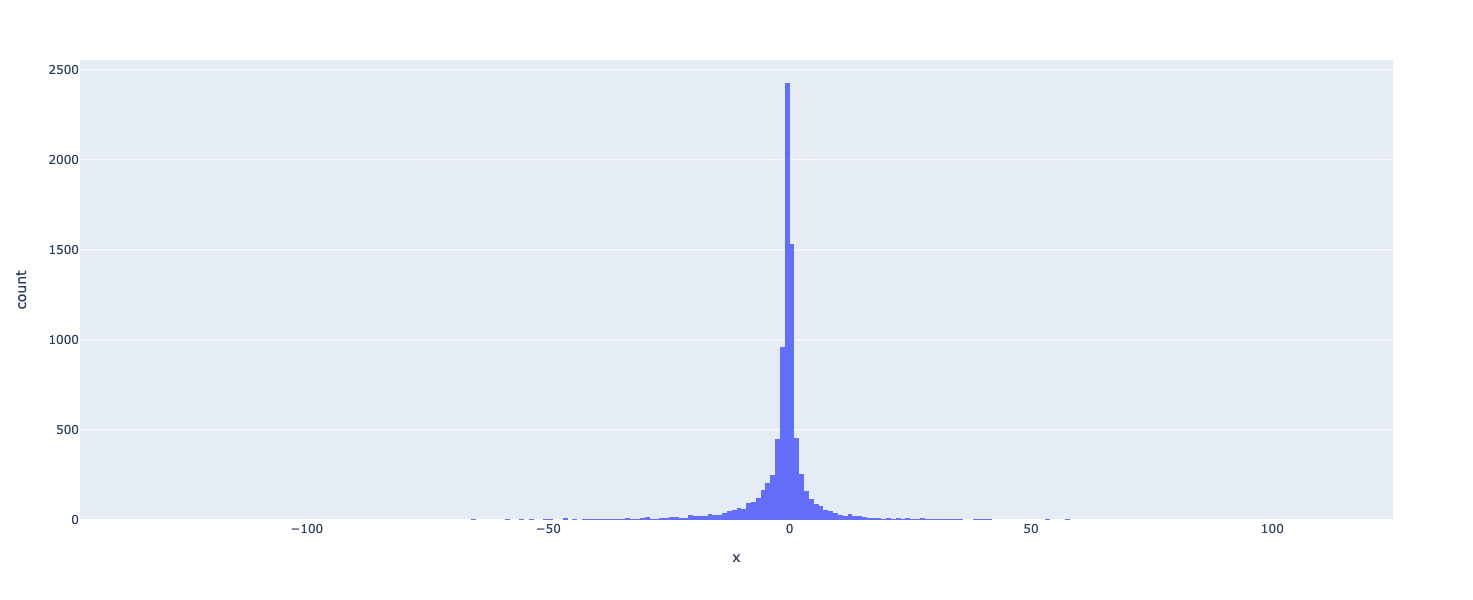

In [18]:
plot_diff_between_stations(data, stations[1], stations[2])

There is a factor which disturbes the normal distribution and skews it towards one side.

## Remove outliers

As there are many sudden changes in data, removing outliers is more tricky here. I will increase the threshold to not remove valuable information.

In [19]:
data_rm_outliers = remove_outliers(data, stations, num_std=6)
data_rm_outliers = interpolate_missing_values(data_rm_outliers, stations)

76 outliers removed for WpPoznDabrow
17 outliers removed for WpPoznPolank
5 outliers removed for WpPoznRatajeMOB
161 values interpolated for WpPoznDabrow
110 values interpolated for WpPoznPolank
16 values interpolated for WpPoznRatajeMOB


The interploation filled missing data only up to 3 concurrent hours and this limit was chosen based on intuiton of the analyst.

How many missing values are left?

In [20]:
data.isnull().sum()

Time                 0
WpPoznDabrow       104
WpPoznPolank        93
WpPoznRatajeMOB     17
dtype: int64

In [21]:
data_rm_outliers.isnull().sum()

Time                0
WpPoznDabrow       19
WpPoznPolank        0
WpPoznRatajeMOB     6
dtype: int64

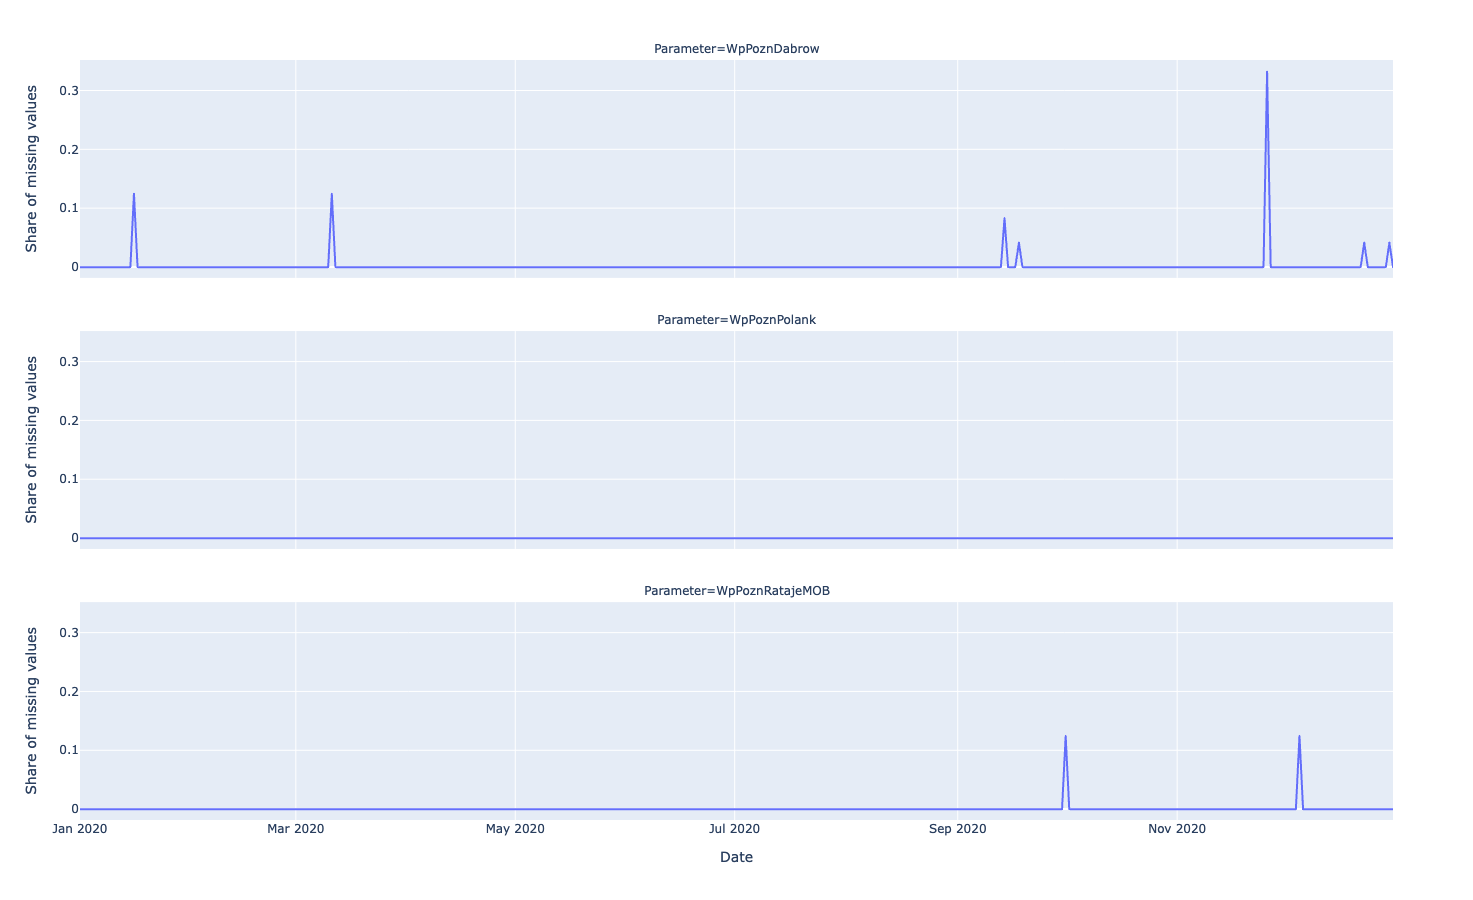

In [22]:
plot_missing_values(data_rm_outliers, stations)

## Calculate final mean value across all the stations

In [23]:
data_mean = calculate_mean_value_across_all_stations(data_rm_outliers, 'NO')

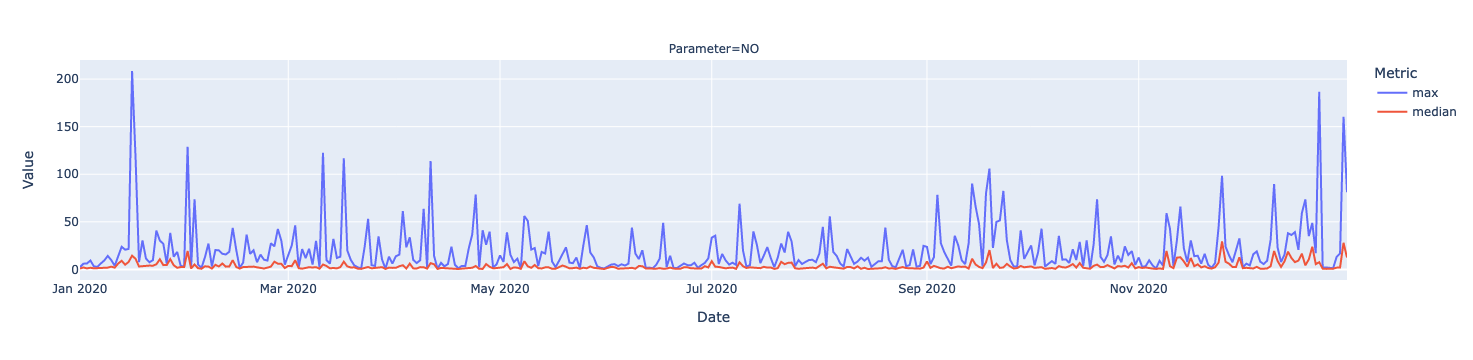

In [24]:
plot_max_median(data_mean, ['NO'])

In [25]:
data_mean.isnull().sum()

Time    0
NO      0
dtype: int64

With data from both stations we covered the entire year.

**Save mean data**

In [26]:
save_mean_data(data_mean, 'NO')